## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)

Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Для ускорения обучения сети рекомендуется подключить GPU (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [26]:
# Максимальное количество уникальных слов слов
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [27]:
import requests
import os

def _wget(url: str, save_path: str):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
        
def _ls(path: str):
    return os.listdir(path)

_wget(url="https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv", save_path="data_lab5/train.csv")

Загружаем данные для тестирования

In [28]:
_wget(url="https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv", save_path="data_lab5/test.csv")

Загружаем имена классов

In [29]:
_wget(url="https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt", save_path="data_lab5/classes.txt")

## Просматриваем данные

In [30]:
_ls(path="data_lab5/")

['classes.txt', 'test.csv', 'train.csv']

## Загружаем данные в память

Читаем данные из файла

In [31]:
train = pd.read_csv('data_lab5/train.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [32]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Выделяем данные для обучения

In [33]:
news = train['text']
# news = train['title'] + ' ' + train['text']

In [34]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Выделяем правильные ответы

In [35]:
# Преобразование целочисленного вектора класса в двоичную матрицу
# Аргументы: вектор классов в данных и общее количество классов
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [36]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], shape=(120000, 4))

## Токенизация текста

In [37]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Создаем токенизатор Keras

<img src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/bc9/feb/314/bc9feb3143af4759aceff629305cf8ae.png">

Принцип работы модуля TextVectorization

In [38]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=num_words,
    output_mode='int',
    output_sequence_length=max_news_len)

In [39]:
vectorize_layer.adapt(news)
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('to'),
 np.str_('of'),
 np.str_('in'),
 np.str_('and'),
 np.str_('on'),
 np.str_('for'),
 np.str_('that'),
 np.str_('39s'),
 np.str_('with'),
 np.str_('as'),
 np.str_('its'),
 np.str_('at'),
 np.str_('is'),
 np.str_('said'),
 np.str_('by'),
 np.str_('it'),
 np.str_('has'),
 np.str_('new'),
 np.str_('an'),
 np.str_('from'),
 np.str_('his'),
 np.str_('us'),
 np.str_('will'),
 np.str_('was'),
 np.str_('reuters'),
 np.str_('after'),
 np.str_('have'),
 np.str_('be'),
 np.str_('their'),
 np.str_('are'),
 np.str_('over'),
 np.str_('ap'),
 np.str_('he'),
 np.str_('but'),
 np.str_('two'),
 np.str_('first'),
 np.str_('this'),
 np.str_('more'),
 np.str_('monday'),
 np.str_('wednesday'),
 np.str_('tuesday'),
 np.str_('thursday'),
 np.str_('company'),
 np.str_('up'),
 np.str_('friday'),
 np.str_('inc'),
 np.str_('one'),
 np.str_('world'),
 np.str_('yesterday'),
 np.str_('they'),
 np.str_('last'),
 np.str_('york'),
 np.str_('against'),
 np.str_

In [40]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [41]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [42]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'is': 17,
 'by': 18,
 'it': 19,
 'has': 20,
 'new': 21,
 'an': 22,
 'from': 23,
 'reuters': 24,
 'his': 25,
 'will': 26,
 'was': 27,
 'after': 28,
 'have': 29,
 'be': 30,
 'their': 31,
 'two': 32,
 'are': 33,
 'us': 34,
 'over': 35,
 'quot': 36,
 'year': 37,
 'first': 38,
 'ap': 39,
 'he': 40,
 'but': 41,
 'gt': 42,
 'lt': 43,
 'this': 44,
 'more': 45,
 'monday': 46,
 'wednesday': 47,
 'one': 48,
 'tuesday': 49,
 'up': 50,
 'thursday': 51,
 'company': 52,
 'inc': 53,
 'friday': 54,
 'world': 55,
 'than': 56,
 'u': 57,
 '1': 58,
 'last': 59,
 'they': 60,
 'york': 61,
 'yesterday': 62,
 'against': 63,
 'about': 64,
 'who': 65,
 'not': 66,
 'were': 67,
 'into': 68,
 'out': 69,
 'three': 70,
 'been': 71,
 'president': 72,
 '2': 73,
 'had': 74,
 'million': 75,
 'corp': 76,
 'oil': 77,
 'when': 78,
 'week': 79,
 'time'

Преобразуем новости в числовое представление

In [43]:
sequences = tokenizer.texts_to_sequences(news)

Просматриваем новости в числовом представлении

In [44]:
index = 1
print(news[index])
print(sequences[index])

Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
[24, 863, 751, 371, 93, 84, 20, 2, 3916, 8, 453, 431, 6, 1308, 2799, 5, 1, 549, 237, 20, 3528, 2002, 14, 8267, 7, 216, 314, 4, 1, 131]


In [45]:
tokenizer.word_index['reuters']

24

Ограничиваем длину текста

In [46]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [47]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

## Сверточная нейронная сеть

In [48]:
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(keras.layers.Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(128, activation='relu'))
model_cnn.add(keras.layers.Dense(4, activation='softmax'))

C:\Users\vadim\Documents\Labs\LabsDataAnalysisAndModeling\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [51]:
# model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_filepath_cnn = '/tmp/ckpt/checkpoint.model_cnn.keras'
checkpoint_callback_cnn = ModelCheckpoint(checkpoint_filepath_cnn,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [52]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7426 - loss: 0.6503
Epoch 1: val_accuracy improved from None to 0.89108, saving model to /tmp/ckpt/checkpoint.model_cnn.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8474 - loss: 0.4249 - val_accuracy: 0.8911 - val_loss: 0.3067
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9182 - loss: 0.2428
Epoch 2: val_accuracy did not improve from 0.89108
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9157 - loss: 0.2475 - val_accuracy: 0.8888 - val_loss: 0.3086
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9371 - loss: 0.1849
Epoch 3: val_accuracy did not improve from 0.89108
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9327 - loss: 0.1942 - val_accuracy: 0.8863 - val_loss: 0.3297
Epoch 4/5
839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9541 - loss: 0.1360
Epoch 4: val_accuracy did not improve from 0.89108
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/st

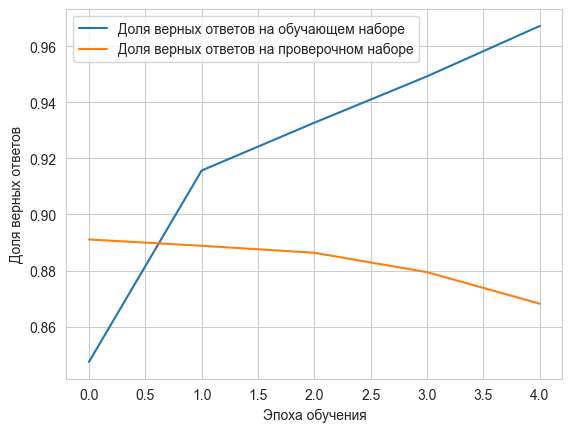

In [53]:
plt.plot(history_cnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [54]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dense(4, activation='softmax'))

In [55]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [57]:
# model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_filepath_lstm = '/tmp/ckpt/checkpoint.model_lstm.keras'
checkpoint_callback_lstm = ModelCheckpoint(checkpoint_filepath_lstm,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [58]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7237 - loss: 0.7330
Epoch 1: val_accuracy improved from None to 0.89117, saving model to /tmp/ckpt/checkpoint.model_lstm.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8372 - loss: 0.4734 - val_accuracy: 0.8912 - val_loss: 0.3147
Epoch 2/5
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9170 - loss: 0.2607
Epoch 2: val_accuracy did not improve from 0.89117
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9130 - loss: 0.2672 - val_accuracy: 0.8850 - val_loss: 0.3192
Epoch 3/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9293 - loss: 0.2198
Epoch 3: val_accuracy did not improve from 0.89117
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9247 - loss: 0.2303 - val_accuracy: 0.8839 - val_loss: 0.3300
Epoch 4/5
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9357 - loss: 0.1983
Epoch 4: val_accuracy did not improve from 0.89117
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/s

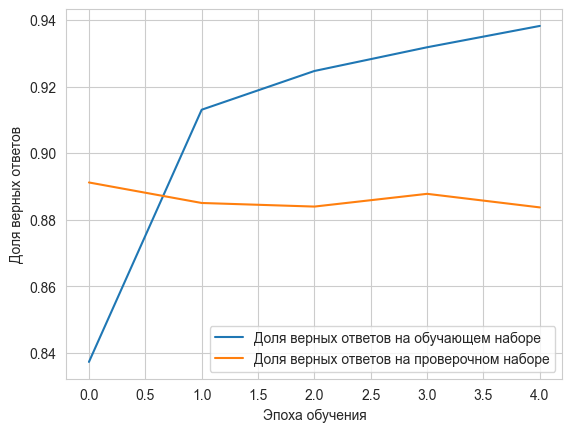

In [59]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [60]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(4, activation='softmax'))

In [61]:
model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [63]:
# model_gru_save_path = 'best_model_gru.h5'
checkpoint_filepath_gru = '/tmp/ckpt/checkpoint.model_gru.keras'
checkpoint_callback_gru = ModelCheckpoint(checkpoint_filepath_gru,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [64]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6613 - loss: 0.8587
Epoch 1: val_accuracy improved from None to 0.88242, saving model to /tmp/ckpt/checkpoint.model_gru.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7957 - loss: 0.5631 - val_accuracy: 0.8824 - val_loss: 0.3342
Epoch 2/5
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9108 - loss: 0.2747
Epoch 2: val_accuracy improved from 0.88242 to 0.88683, saving model to /tmp/ckpt/checkpoint.model_gru.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9093 - loss: 0.2773 - val_accuracy: 0.8868 - val_loss: 0.3186
Epoch 3/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9243 - loss: 0.2331
Epoch 3: val_accuracy did not improve from 0.88683
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9215 - loss: 0.2403 - val_accuracy: 0.8865 - val_loss: 0.3187
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9332 - loss: 0.2089
Epoch 4: val_accuracy did not imp

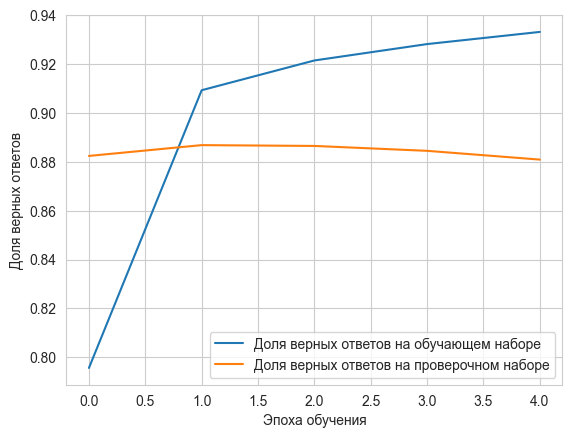

In [65]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [66]:
test = pd.read_csv('test.csv',
                    header=None,
                    names=['class', 'title', 'text'])

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
test

Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [ ]:
x_test[:5]

Правильные ответы

In [ ]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [ ]:
y_test

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть

In [ ]:
model_cnn.load_weights(checkpoint_filepath_cnn)

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

### Сеть LSTM

In [ ]:
model_lstm.load_weights(checkpoint_filepath_lstm)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

### Сеть GRU

In [ ]:
model_gru.load_weights(checkpoint_filepath_gru)

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)

## Задание

1. Попробовать улучшить предсказание моделей за счет использования не только текста, но и заголовка новости.
При этом рекомендуется увеличить максимальню длину текста. <br/>
2. Проверить, как на качеаство предсказания влияет предобработка текста (удаление стоп-слов, пунктуации, лемматизация и др.)
3. Применить методы регуляризации для устранения переобучения моделей.


## Стоп-слова и пунктуация

**Стоп-слова** - это слова, которые часто встречаются практически в любом тексте и не несут полезной информации о конретном документе. Для модели это просто шум. А шум нужно убирать. По аналогичной причине убирают и пунктуацию.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# импортируем стоп-слова из библиотеки nltk
from nltk.corpus import stopwords

# посмотрим на стоп-слова для английского языка
print(stopwords.words('english'))

*Знаки* пунктуации лучше импортировать из модуля **String**. В нем хранятся различные наборы констант для работы со строками (пунктуация, алфавит и др.).

In [ ]:
from string import punctuation
punctuation



Объединим стоп-слова и знаки пунктуации вместе и запишем в переменную noise:


In [ ]:
noise = stopwords.words('english') + list(punctuation)

## Лемматизация

**Лемматизация** – это сведение разных форм одного слова к начальной форме – **лемме**. Почему это хорошо?
* Во-первых, естественно рассматривать как отдельный признак каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
news = list(lemmatizer.lemmatize(word) for word in news)

## Полезные ссылки

1. [Как понять LSTM сети](https://alexsosn.github.io/ml/2015/11/17/LSTM.html)
2. [Рекуррентные нейронные сети в Keras](https://keras.io/layers/recurrent/)
3. [Регуляризуем правильно!](https://telegra.ph/Regulyarizuem-pravilno-09-20)
4. [12 основных методов Dropout](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293?source=topic_page---------6------------------1)